# Search Engine for Clinical Trial

In [1]:
!pip install wordcloud

In [78]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#Mounting our google drive on google colab to access our data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load the dataset
filepath = '/content/drive/MyDrive/clinical-trail-search-engine/Data/Covid19_clinical_trials.csv'
trial_data=pd.read_csv(filepath)
trial_data_copy = trial_data.copy()
trial_data.head(5)

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-09-01,NCT05029245,"The 8-week, Prospective, Randomized Controlled...",IntraDermal Versus Intramuscular Comirnaty® Ef...,PRIDE,"The 8-week, Prospective, Randomized controlled...",2021-08-31,2021; 2022,Phase 3,Covid19 Vaccine; Covid19,...,All,ClinicalTrials.gov,NaN,Rajavithi Hospital,grid.415633.6,Thailand,NaN,NaN,https://clinicaltrials.gov/show/NCT05029245,https://app.dimensions.ai/details/clinical_tri...
1,2021-09-01,NCT05029037,High-dose Intravenous Vitamin C (HDIVC) as Adj...,High-dose Intravenous Vitamin C (HDIVC) as Adj...,HDIVC,The objective of this study is to evaluate the...,2021-09-15,2021; 2022,Phase 3,Covid19,...,All,ClinicalTrials.gov,NaN,NaN,NaN,NaN,NaN,NaN,https://clinicaltrials.gov/show/NCT05029037,https://app.dimensions.ai/details/clinical_tri...
2,2021-09-01,NCT05029011,Low-cost Sensor System for COVID-19 Patient Mo...,Low-cost Sensor System for COVID-19 Patient Mo...,NaN,"The MediByte VTS is a low-cost, portable devic...",2021-09-01,2021; 2022,NaN,The Focus is How Well the MediByte VTS Will Mo...,...,All,ClinicalTrials.gov,Helen Driver,Queen's University; National Research Council ...,grid.410356.5; grid.24433.32,Canada; Canada,National Research Council Canada,Canada,https://clinicaltrials.gov/show/NCT05029011,https://app.dimensions.ai/details/clinical_tri...
3,2021-09-01,NCT05028998,The Impact of COVID-19-related Medication Assi...,Covid-related Opioid Treatment Policy Evaluation,COPE,Our nation is facing the COVID-19 pandemic dur...,2021-09-01,2021; 2022; 2023,NaN,Opioid-use Disorder; Alcohol Use Disorder,...,All,ClinicalTrials.gov,NaN,Boston University; Patient-Centered Outcomes R...,grid.189504.1; grid.430109.f; grid.417499.6; g...,United States; United States; United States; U...,Patient-Centered Outcomes Research Institute; ...,United States; United States,https://clinicaltrials.gov/show/NCT05028998,https://app.dimensions.ai/details/clinical_tri...
4,2021-09-01,NCT05028881,Serological Responses to SARS-CoV-2 and Their ...,Hong Kong HIV SARS-CoV-2 Serology,NaN,Immunodeficiency associated with human immunod...,2020-05-16,2020; 2021; 2022; 2023,NaN,HIV Infections; SARS-CoV-2 Infection; Vaccinat...,...,All,ClinicalTrials.gov,Shui Shan Lee,Chinese University of Hong Kong,grid.10784.3a,China,NaN,NaN,https://clinicaltrials.gov/show/NCT05028881,https://app.dimensions.ai/details/clinical_tri...


In [5]:
display(trial_data.shape)
display(trial_data.info())

(12129, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Date added                       12129 non-null  object
 1   Trial ID                         12129 non-null  object
 2   Title                            12129 non-null  object
 3   Brief title                      11696 non-null  object
 4   Acronym                          4051 non-null   object
 5   Abstract                         12127 non-null  object
 6   Publication date                 12129 non-null  object
 7   Active years                     11061 non-null  object
 8   Phase                            4719 non-null   object
 9   Conditions                       11911 non-null  object
 10  Intervention                     8947 non-null   object
 11  Gender                           12129 non-null  object
 12  Registry                        

None

In [6]:
str(trial_data['Abstract'][0])

'The 8-week, Prospective, Randomized controlled of IntraDermal administration of Comirnaty® 6 microgram compare to Intramuscular Comirnaty® 30 microgram by 28 days interval Efficacy Study in 4 groups of healthy volunteer ( 1 people who complete sinovac vaccination 2 people who received 1 dosage of AstraZeneca vaccine 3 naive vaccination 4 any other vaccination not in 1-3 with anti Spike antibody less than 650 AU/ ml) . Comparison of antibody level and T cell response to SAR-CoV-2 antigen in vitro after 28 day post vaccination is primary outcome and the side effect as well as infection rate in 8 weeks is secondary outcomes.\n\nDetailed Description\nThe 8-week, Prospective, Randomized controlled of IntraDermal administration of Comirnaty® 6 microgram compare to Intramuscular Comirnaty® 30 microgram by 28 days interval Efficacy Study in healthy volunteer.To compare the AntiSpike antibody, ( Anti RBD ) neutralized antibody ( if possible) of SAR-CoV-2 and T-cell response after injection wit

### Data Preprocessing

In [7]:
# Function to lemmatize Words
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

#function for data preprocessing of texts
def pre_processing(text):

  text = text.lower()
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(text)).split()) #remove urls
  text = re.sub(r'\d+', '', str(text)) #emove no.s
  text=text.replace('\n',' ')
  text = word_tokenize(text)
  text = [char for char in text if char not in string.punctuation]
  text = [word for word in text if word not in stopwords.words('english')]
  text = lemmatize(text)
  text = ' '.join(text)
  return text

In [8]:
#Applying preprocessing for Abstract and Title columns

trial_data['Abstract'] = trial_data['Abstract'].replace(np.nan, '')
trial_data['Title'] = trial_data['Title'].replace(np.nan, '')

for i in range(trial_data.shape[0]):
  trial_data['Abstract'][i]=pre_processing(str(trial_data['Abstract'][i]))
  trial_data['Title'][i]=pre_processing(str(trial_data['Title'][i]))

trial_data.head(5)

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-09-01,NCT05029245,week prospective randomized controlled intrade...,IntraDermal Versus Intramuscular Comirnaty® Ef...,PRIDE,week prospective randomized controlled intrade...,2021-08-31,2021; 2022,Phase 3,Covid19 Vaccine; Covid19,...,All,ClinicalTrials.gov,NaN,Rajavithi Hospital,grid.415633.6,Thailand,NaN,NaN,https://clinicaltrials.gov/show/NCT05029245,https://app.dimensions.ai/details/clinical_tri...
1,2021-09-01,NCT05029037,high dose intravenous vitamin c hdivc adjuvant...,High-dose Intravenous Vitamin C (HDIVC) as Adj...,HDIVC,objective study evaluate impact hdivc therapy ...,2021-09-15,2021; 2022,Phase 3,Covid19,...,All,ClinicalTrials.gov,NaN,NaN,NaN,NaN,NaN,NaN,https://clinicaltrials.gov/show/NCT05029037,https://app.dimensions.ai/details/clinical_tri...
2,2021-09-01,NCT05029011,low cost sensor system covid patient monitorin...,Low-cost Sensor System for COVID-19 Patient Mo...,NaN,medibyte vt low cost portable device developed...,2021-09-01,2021; 2022,NaN,The Focus is How Well the MediByte VTS Will Mo...,...,All,ClinicalTrials.gov,Helen Driver,Queen's University; National Research Council ...,grid.410356.5; grid.24433.32,Canada; Canada,National Research Council Canada,Canada,https://clinicaltrials.gov/show/NCT05029011,https://app.dimensions.ai/details/clinical_tri...
3,2021-09-01,NCT05028998,impact covid related medication assisted treat...,Covid-related Opioid Treatment Policy Evaluation,COPE,nation facing covid pandemic ongoing opioid ep...,2021-09-01,2021; 2022; 2023,NaN,Opioid-use Disorder; Alcohol Use Disorder,...,All,ClinicalTrials.gov,NaN,Boston University; Patient-Centered Outcomes R...,grid.189504.1; grid.430109.f; grid.417499.6; g...,United States; United States; United States; U...,Patient-Centered Outcomes Research Institute; ...,United States; United States,https://clinicaltrials.gov/show/NCT05028998,https://app.dimensions.ai/details/clinical_tri...
4,2021-09-01,NCT05028881,serological response sars cov temporal pattern...,Hong Kong HIV SARS-CoV-2 Serology,NaN,immunodeficiency associated human immunodefici...,2020-05-16,2020; 2021; 2022; 2023,NaN,HIV Infections; SARS-CoV-2 Infection; Vaccinat...,...,All,ClinicalTrials.gov,Shui Shan Lee,Chinese University of Hong Kong,grid.10784.3a,China,NaN,NaN,https://clinicaltrials.gov/show/NCT05028881,https://app.dimensions.ai/details/clinical_tri...


In [9]:
#Tokenize
tokens = [word_tokenize(word) for word in trial_data.Abstract ]

### EDA

In [10]:
#Find most common(top) words
from collections import Counter
count = Counter()
for text in trial_data.Abstract:
  for word in text.split():
    count[word] += 1

count.most_common(10)  #10 most common words

[('patient', 43187),
 ('covid', 43063),
 ('study', 37002),
 ('group', 15111),
 ('treatment', 14052),
 ('day', 14029),
 ('sars', 12882),
 ('cov', 12855),
 ('disease', 12853),
 ('clinical', 12847)]

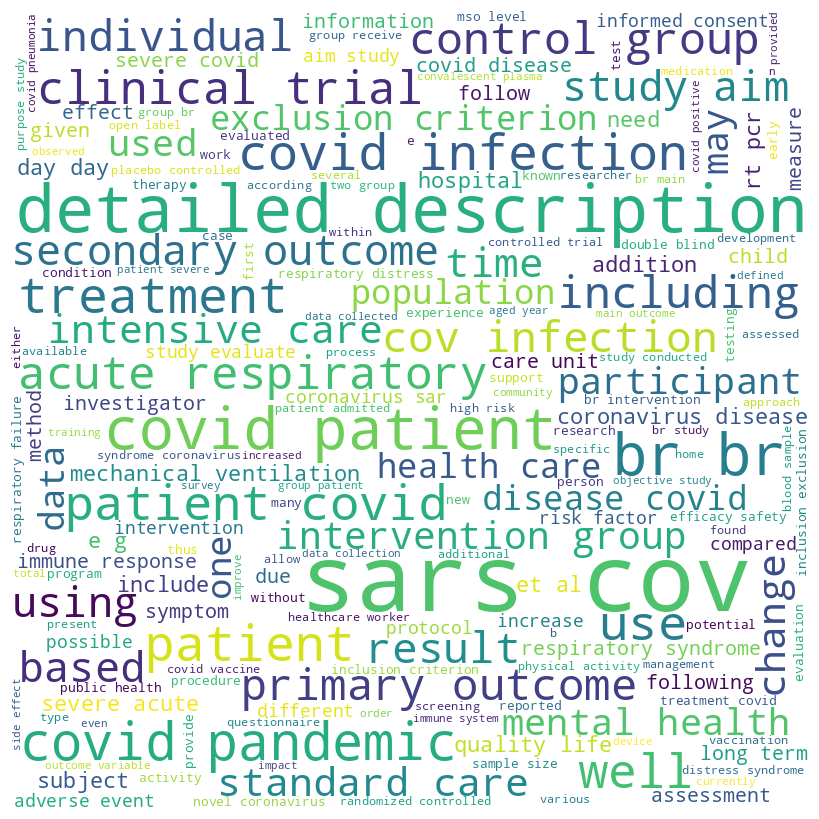

In [11]:
#creating word cloud from our tokens generated post preprocessing of Abstract column
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#comment_words = ' '
stopwords = set(STOPWORDS)
from pandas.core.common import flatten

# iterate through the csv file


word_cloud=flatten(tokens)
word_cloud=' '.join(word_cloud)


wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(word_cloud)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Word2Vec Skipgram model

##### At a high level Word2Vec is a unsupervised learning algorithm that uses a shallow neural network (with one hidden layer) to learn the vectorial representations of all the unique words/phrases for a given corpus.

The advantage that word2vec offers is it tries to preserve the semantic meaning behind those terms. For example, a document may employ the words "dog" and "canine" to mean the same thing, but never use them together in a sentence. Ideally, the word2vec algorithm would be able to learn the context and place them together in similar vector semantic space.
Skip-gram variant takes a target word and tries to predict the surrounding context words
>**window size**

Word2Vec has 'window' hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).
> **min_count**

min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:
default value of min_count=5
>**vector_size**

vector_size is the number of dimensions (N) of the N-dimensional space that gensim Word2Vec maps the words onto.
Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.
>**workers**

workers , the last of the major parameters is for training parallelization, to speed up training. The workers parameter only has an effect if you have Cython installed. Without Cython, you’ll only be able to use one core because of the GIL (and word2vec training will be miserably slow).
>**Memory**

At its core, word2vec model parameters are stored as matrices (NumPy arrays). Each array is #vocabulary (controlled by the min_count parameter) times vector size (the vector_size parameter) of floats (single precision aka 4 bytes).
Three such matrices are held in RAM (work is underway to reduce that number to two, or even one). So if your input contains 100,000 unique words, and you asked for layer vector_size=200, the model will require approx. 100,000*200*4*3 bytes = ~229MB.

There’s a little extra memory needed for storing the vocabulary tree (100,000 words would take a few megabytes), but unless your words are extremely loooong strings, memory footprint will be dominated by the three matrices above.

>**sg** ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

>**hs** ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.

>**negative** (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
>**alpha** (float, optional) – The initial learning rate.

>**min_alpha** (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

In [12]:
#training skipgram model for window = 3
skipgram = Word2Vec(tokens, vector_size =50, window = 3, min_count=2,sg = 1)
print(skipgram)
skipgram.save('skipgramx1.bin')

Word2Vec<vocab=27307, vector_size=50, alpha=0.025>


In [13]:
#training skipgram model for window = 1
skipgram = Word2Vec(tokens, vector_size =100, window = 1, min_count=2,sg = 1)
print(skipgram)
skipgram.save('skipgramx11.bin')

Word2Vec<vocab=27307, vector_size=100, alpha=0.025>


In [14]:
#training fasttext Model, with skipgram
FastText=FastText(tokens,vector_size=100, window=2, min_count=2, workers=5, min_n=1, max_n=2,sg=1)
FastText.save('FastText.bin')


In [82]:
# Loading the model skipgram and fasttext model
skipgram1 = Word2Vec.load('skipgramx1.bin')
skipgram = Word2Vec.load('skipgramx11.bin')
FastText = Word2Vec.load('FastText.bin')

In [16]:
# Similar words - skipgram
skipgram.wv.most_similar(positive=['covid'],topn=10)


[('sars', 0.7947479486465454),
 ('ncp', 0.7788784503936768),
 ('covd', 0.7708003520965576),
 ('cov', 0.7589846253395081),
 ('virologically', 0.7513934373855591),
 ('sari', 0.7422683238983154),
 ('sarscov', 0.7394090294837952),
 ('pasc', 0.7373050451278687),
 ('corona', 0.7359883189201355),
 ('kazakhstan', 0.7352629899978638)]

In [17]:
skipgram1.wv.most_similar(positive=['covid'],topn=10)

[('covd', 0.837303876876831),
 ('ncip', 0.8330796957015991),
 ('sars', 0.8244176506996155),
 ('cov', 0.8184897303581238),
 ('ncp', 0.8131253719329834),
 ('classifying', 0.8034284114837646),
 ('virologically', 0.8012529015541077),
 ('acutely', 0.7978293299674988),
 ('coivd', 0.7957695126533508),
 ('ald', 0.795609712600708)]

In [18]:
skipgram.wv.most_similar(positive=['day'],topn=10)

[('hour', 0.7977759838104248),
 ('upto', 0.7816125154495239),
 ('fourteen', 0.7636117339134216),
 ('hourly', 0.7602484822273254),
 ('vfd', 0.7510895729064941),
 ('week', 0.7509405612945557),
 ('eos', 0.750271737575531),
 ('eot', 0.7419750690460205),
 ('till', 0.7159780859947205),
 ('night', 0.7142776250839233)]

In [19]:
skipgram1.wv.most_similar(positive=['day'],topn=10)

[('hour', 0.8688768148422241),
 ('fourteen', 0.867106556892395),
 ('hourly', 0.8609620928764343),
 ('upto', 0.8582348823547363),
 ('vfd', 0.8353778719902039),
 ('week', 0.8352169394493103),
 ('elapsed', 0.8306775689125061),
 ('eot', 0.8304079174995422),
 ('coincide', 0.8234826326370239),
 ('eos', 0.8218869566917419)]

In [20]:
# Similar words - fasttext

FastText.wv.most_similar(positive=['lung'],topn=10)

[('lungiq', 0.7320566177368164),
 ('leung', 0.7066224217414856),
 ('pulmonary', 0.684548020362854),
 ('angiography', 0.6622584462165833),
 ('hocaoglu', 0.6602195501327515),
 ('voluntary', 0.6601885557174683),
 ('cholangiopancreatography', 0.6586894989013672),
 ('capnography', 0.6548410654067993),
 ('ltigung', 0.654013454914093),
 ('sung', 0.6522002220153809)]

In [21]:
FastText.wv.most_similar(positive=['breathing'],topn=10)

[('breaching', 0.9204834699630737),
 ('rebreathing', 0.9139516353607178),
 ('breathes', 0.8999629020690918),
 ('breathe', 0.8973867297172546),
 ('breathed', 0.8696339726448059),
 ('nosebreathing', 0.8673390746116638),
 ('breath', 0.8611645698547363),
 ('bathing', 0.8549342751502991),
 ('breaking', 0.8530505895614624),
 ('heating', 0.8499892354011536)]

### Plotting th word embeddings

In [31]:
#Function to plot word embeddings with skipgram & FastText
def plot_func(algo):
  X = algo.wv[algo.wv.index_to_key]

  #applying PCA to convert data into two dimensions
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  #convert the word embedding array into dataframe with 2 dimensions
  word_embedding = pd.DataFrame(result,columns=['d0', 'd1'])
  word_embedding.index = algo.wv.index_to_key
  #plot 2-D representation of each word
  pyplot.scatter(word_embedding.iloc[:15,0],word_embedding.iloc[:15,1])
  for i, word in enumerate(word_embedding.index[:15]):
    pyplot.annotate(word, xy=(word_embedding.iloc[i,0],word_embedding.iloc[i,1]))
  #pyplot.title(algo)
  pyplot.show()



>with Skipgram

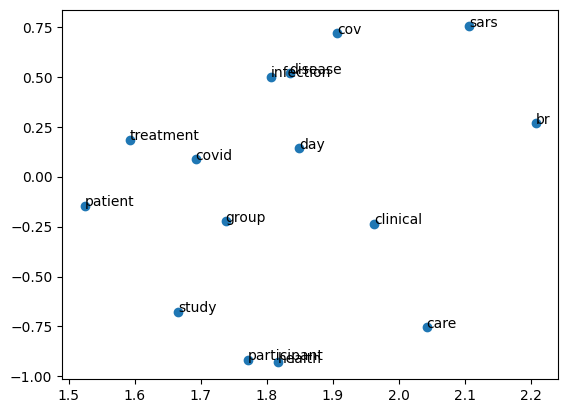

In [32]:
plot_func(skipgram)

>with FastText

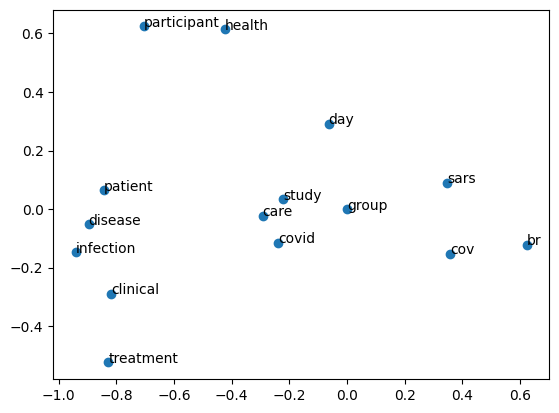

In [33]:
plot_func(FastText)

In [41]:
FastText.wv['lung'].reshape(100,1)

array([[-4.10435855e-01],
       [ 2.61502922e-01],
       [ 1.23889325e-02],
       [ 1.63797382e-02],
       [-6.43540844e-02],
       [-5.60040236e-01],
       [ 8.44526291e-02],
       [-5.31577051e-01],
       [-3.53490770e-01],
       [-2.90568352e-01],
       [ 5.96119285e-01],
       [-4.57453638e-01],
       [-2.51574755e-01],
       [ 5.57210386e-01],
       [ 1.80275097e-01],
       [ 3.10122102e-01],
       [-2.01402195e-02],
       [-1.10955954e-01],
       [-5.52884042e-02],
       [ 3.33041251e-01],
       [ 1.91297293e-01],
       [-1.45999208e-01],
       [-5.81675410e-01],
       [ 8.50424692e-02],
       [-7.78691709e-01],
       [-1.58909887e-01],
       [-5.20472303e-02],
       [-5.64311385e-01],
       [-1.87881395e-01],
       [-1.98553160e-01],
       [-1.80795535e-01],
       [-2.79972076e-01],
       [-5.97503074e-02],
       [ 8.99244770e-02],
       [ 1.59022689e-01],
       [-3.21306348e-01],
       [ 1.70924991e-01],
       [-6.24950454e-02],
       [ 1.7

In [37]:
np.mean(FastText.wv['lung'])

0.00014013945

In [42]:
#Function to take average of all vectors of each word in abstract, so that each abstract can represent (1,100) dimensional vector
def get_mean_vector(word2vec_model, words):
    # remove oov words
    words = [word for word in word_tokenize(words) if word in list(word2vec_model.wv.index_to_key)] #if word is in vocab
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.array([0]*100)

Converting Abstract column text-values into Vectors using **Skipgram**

In [57]:
abstract_word_vec =[]                                     #defining empty list
for i in trial_data.Abstract:
    abstract_word_vec.append(list(get_mean_vector(skipgram, i)))     #appending array to the list


abstract_vec=pd.DataFrame(abstract_word_vec).transpose()    # Saving vectors of each abstract in data frame so that we can use directly while running code again
abstract_vec.to_csv('skipgram-vec.csv')

In [58]:
abstract_vec

,0,1,2,3,4,5,6,7,8,9,...,12119,12120,12121,12122,12123,12124,12125,12126,12127,12128
0,-0.367969,-0.407851,-0.387087,-0.385841,-0.387365,-0.509773,-0.297312,-0.495605,-0.314669,-0.378066,...,-0.469441,-0.431571,-0.377643,-0.362655,-0.342842,-0.385959,-0.463931,-0.395544,-0.389484,-0.433521
1,0.222207,0.418582,0.269099,0.412330,0.164696,0.349857,0.256050,0.330292,0.315783,0.424968,...,0.341632,0.371182,0.416506,0.334155,0.268568,0.338438,0.392113,0.237242,0.214636,0.412148
2,0.226268,0.347153,0.200770,0.124690,0.300961,0.185402,0.253288,0.349395,0.224733,0.227920,...,0.112980,0.284478,0.169278,0.139368,0.161418,0.228379,0.195766,0.235789,0.228166,0.168541
3,0.026483,0.100252,-0.034304,0.024894,0.051487,0.078436,0.110930,-0.128974,0.050181,0.154879,...,-0.100300,-0.057628,-0.046395,-0.001895,-0.056660,0.038515,-0.101846,0.185183,0.166397,-0.090248
4,-0.022696,0.055965,-0.047380,-0.015881,-0.045350,-0.020212,0.015366,-0.006161,-0.073881,0.043409,...,0.036890,-0.039595,0.014789,-0.050596,0.022938,-0.088275,0.012227,-0.084756,-0.108697,-0.052919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.426476,0.424353,0.450886,0.476604,0.556884,0.546349,0.521843,0.507133,0.543241,0.440107,...,0.546327,0.482916,0.502027,0.320548,0.351866,0.483359,0.566516,0.432939,0.407145,0.513254
96,0.065239,0.093248,0.067325,0.181283,0.080240,0.154080,0.031317,-0.043758,0.054207,0.035137,...,0.120435,0.105017,0.115890,0.172767,0.109679,0.044053,0.085823,0.136480,0.154315,0.071883
97,-0.341068,-0.222120,-0.213604,-0.189135,-0.250109,-0.178973,-0.374922,-0.404911,-0.240596,-0.095874,...,-0.268998,-0.252870,-0.240393,-0.306428,-0.189739,-0.276119,-0.265416,-0.238490,-0.207257,-0.300372
98,0.118010,0.140121,0.155480,0.240603,0.125002,0.154762,0.093397,0.117484,0.094948,0.047728,...,0.256531,0.179990,0.244533,0.104907,0.075643,0.140214,0.239166,0.085856,0.108632,0.216736


In [59]:
word_vec[str(0)].values

array([-3.67968589e-01,  2.22206831e-01,  2.26268426e-01,  2.64830776e-02,
       -2.26961058e-02, -4.65168834e-01,  1.19710110e-01,  5.66750824e-01,
       -8.82532001e-02, -1.25581041e-01, -1.72625721e-01, -2.01997697e-01,
       -6.56608492e-02,  2.47406870e-01,  3.95073295e-01, -1.47949398e-01,
       -5.77277467e-02, -2.96126157e-01, -8.52258727e-02, -6.88887060e-01,
        1.50894746e-02,  1.41187191e-01,  3.39601971e-02, -1.86526194e-01,
       -4.74307016e-02, -1.91633001e-01, -1.56913012e-01, -5.28109819e-02,
       -3.47327620e-01, -1.60498649e-01,  2.59197831e-01,  9.12794005e-03,
       -5.05014614e-04, -3.03575218e-01, -1.40849471e-01,  4.52175885e-01,
        5.20387590e-02, -1.46438265e-02, -1.49908781e-01, -4.43955004e-01,
        1.24216877e-01, -3.36173922e-01,  7.49005973e-02, -4.57122326e-02,
        1.40327528e-01,  1.02287866e-01, -3.86001945e-01,  1.19267749e-02,
        1.71620294e-01,  4.93723780e-01,  2.24095345e-01,  6.41096160e-02,
        1.31311655e-01,  

In [60]:
#Loading our pretrained vectors of each abstract
word_vec=pd.read_csv('skipgram-vec.csv')

skipgram_vectors=[]
for i in range(trial_data.shape[0]):
    skipgram_vectors.append(word_vec[str(i)].values)

Converting Title column into vectors using skipgram

In [61]:
title_word_vec=[]
for i in trial_data.Title:
    title_word_vec.append(list(get_mean_vector(skipgram, i)))


title_vec=pd.DataFrame(title_word_vec).transpose()
title_vec.to_csv('skipgram-vec-title.csv')

In [62]:
#Loading our pretrained vectors of each title
title_vec = pd.read_csv('skipgram-vec-title.csv')

skipgram_vectors_title=[]
for i in range(trial_data.shape[0]):
    skipgram_vectors_title.append(title_vec[str(i)].values)

Converting Abstract column text-values into Vectors using **FastText**

In [62]:
K_fast=[]                                     #defining empty list
for i in trial_data.Abstract:
    K_fast.append(list(get_mean_vector(FastText, i)))     #appending array to the list

K11=pd.DataFrame(K_fast).transpose()    # Saving vectors of each abstract in data frame so that we can use directly while running code again
K11.to_csv('FastText-vec.csv')

In [64]:
#function to generate word vectors for particular column
def vec_func(model_name, data_col):
  word_vec = []
  for data in data_col:
    word_vec.append(list(get_mean_vector(model_name, data)))

  word_vec_df = pd.DataFrame(word_vec).transpose()
  return word_vec_df


Converting Abstract & Title into vectors using _**skipgram**_

In [62]:
sg_vec_abstract_df = vec_func(skipgram,trial_data.Abstract)
sg_vec_title_df = vec_func(skipgram,trial_data.Title)

Converting Abstract & Title into vectors using _**FastText**_

In [66]:
ft_vec_abstract_df = vec_func(FastText,trial_data.Abstract)
ft_vec_title_df = vec_func(FastText,trial_data.Title)

In [69]:
# Saving vectors of each abstract in data frame so that we can use directly while running code again
sg_vec_abstract_df.to_csv('skipgram_abstract_vec.csv')
sg_vec_title_df.to_csv('skipgram_title_vec.csv')
ft_vec_abstract_df.to_csv('fastText_abstract_vec.csv')
ft_vec_title_df.to_csv('fastText_title_vec.csv')

In [71]:
#defining function to define cosine similarity
def cos_sim(a,b):

    return dot(a, b)/(norm(a)*norm(b))

In [72]:
#Preprocessing input, because input should be in same form as training data set
def preprocessing_input(query,word2vec_model):
    query=pre_processing(query)
    query=query.replace('\n',' ')
    K=get_mean_vector(word2vec_model,query)


    return K

In [75]:
pd.set_option("display.max_colwidth", -1)       #this function will display full text from each column

In [76]:
#function to return top n similar results
def top_n(query,p,df,model):
    print(query)

    query=preprocessing_input(query,model)    #preprocessing input to list of vectors

    x=[]
    #Converting cosine similarities of overall data set with input queries into LIST
    for i in range(len(p)):
        x.append(cos_sim(query,p[i]))


 #store list in tmp to retrieve index
    tmp=list(x)

 #sort list so that largest elements are on the far right

    res = sorted(range(len(x)), key = lambda sub: x[sub])[-5:]
    sim=[tmp[i] for i in reversed(res)]
    print(sim)
 #get index of the 10 or n largest element
    L=[]
    for i in reversed(res):

        L.append(i)
    return df.iloc[L, [1,2,5,6]],sim  #only returning dataframe with id,title,abstract ,publication date

### Search Results

In [79]:
#Loading our pretrained vectors of each abstract in skipgram model
sg_vec = pd.read_csv('skipgram-vec.csv')
skipgram_vectors=[]
for i in range(trial_data_copy.shape[0]):
    skipgram_vectors.append(sg_vec[str(i)].values)

#Input your search query here
Query = "lung failure"

Results,sim = top_n(Query,skipgram_vectors,trial_data_copy,skipgram)
Results

lung failure
[0.8029511009328435, 0.7966024711920079, 0.7862346521653836, 0.7836180451868352, 0.7836156100863947]


,Trial ID,Title,Abstract,Publication date
1899,2021-000988-68,Immune response after covid-19 vaccination in patients with renal failure stadium 4 or 5 .,Renal failure stage 4 and 5.,2021-03-31
5647,NCT04597853,"Assessment of Lung Mechanics in SARS-CoV-2/ COVID-19 Acute Respiratory Distress Syndrome: A Holistic, Longitudinal Analysis of the Lung-heart-ventilator Interaction","This study is meant to assess the lung mechanics in SARS-CoV-2 induced acute respiratory failure. A precise characterisation of lung mechanics and heart-lung-interactions might allow a better understanding of SARS-CoV-2 induced acute respiratory failure and thus lead to better mechanical ventilation strategies.This monocentric, observational study of critically ill COVID-19 patients in the ICU, will employ impedance tomography, right-heart catheterization, oesophageal pressure measurements, indirect calorimetry as well as classic mechanical ventilation parameters to characterise the mechanical characteristics of the lung as well as the heart-lung interactions in SARS-CoV-2 induced acute respiratory failure.",2021-03-01
5743,NCT04588441,Aerosolized Inhaled Adenosine Treatment in Patients With Acute Respiratory Distress Syndrome (ARDS) Caused by COVID-19 (The ARCTIC Trial),"This is a phase II study to test adenosine efficacy for down-regulation of the overwhelming inflammation of COVID-19 in the lungs as reflected by clinical recovery of lung function; resolution of clinically relevant markers of lung function, and resolution of systemic markers of inflammation and coagulation.",2021-09-01
9270,2020-001807-18,"A Phase 2, Randomized, Double-Blind, Placebo-Controlled, Parallel-group, Multi-center Study of an Inhaled Pan-Janus Kinase Inhibitor, TD-0903, to Treat Symptomatic Acute Lung Injury Associated with COVID-19",Acute lung injury associated with COVID-19,2020-10-13
11571,CHICTR2000030578,Clinical Prediction and Intervention of Pulmonary Function Impairment in Patients with Novel Coronavirus Pneumonia (COVID-19),"1. Establish a cohort of survivors of new coronavirus pneumonia, track their lung function damage and changes after discharge, and establish a predictive model of lung function impairment of new coronavirus pneumonia;\n2. Explore lung rehabilitation in patients with impaired lung function effect.",2020-02-01


In [83]:
#Loading our pretrained vectors of each abstract in FastText model
ft_vec = pd.read_csv('fastText_abstract_vec.csv')
FastText_vectors=[]
for i in range(trial_data_copy.shape[0]):
    FastText_vectors.append(ft_vec[str(i)].values)

#Input your search query here

Query = "breathe"

Results,sim=top_n(Query,FastText_vectors,trial_data_copy,FastText)
Results

breathe
[0.7946393887319354, 0.7798952438687564, 0.779448021024104, 0.7788105604655553, 0.7785365725372378]


,Trial ID,Title,Abstract,Publication date
4798,CHICTR2000040388,A prospective randomized control study comparing modified oropharyngeal airway with Guedel's airway for tracheal tube exchange and smooth extubation in gynecological laparoscopic surgery,"With the outbreak of COVID-19, extubation and cough in patients with perioperative intubation during recovery has become a more serious problem. Extubation under deep anesthesia can reduce the reflex of cough to a certain extent and reduce the spread of the epidemic.However, extubation under deep anesthesia may cause respiratory obstruction, and the placement of oropharyngeal airway after extubation can keep the pharynx unblocked and normal breathing.But the traditional oropharyngeal airway can induce restlessness, nausea, vomiting, coughing and even increased heart rate and blood pressure.\nIn this study, the hemodynamic fluctuation and choking were observed after the traditional oropharyngeal airway (OROPharyngeal airway) and the improved oropharyngeal airway (ORopharyngeal airway) were placed after extubation, so as to provide some evidences to support the extensive clinical application of such improved oropharyngeal airway (ORopharyngeal airway).",2020-11-01
3546,CHICTR2100043210,"Traditional Chinese medicine auricular point acupressure for the relief of pain, fatigue, and gastrointestinal adverse reactions after the injection of novel coronavirus-19 vaccines: a multicentre, three-arm, single-blind, prospective randomized controlled trial","To investigate whether traditional Chinese medicine auricular point acupressure can alleviate and (or) reduce the pain (including injection site pain, headache, other muscle and joint pain), fatigue, and gastrointestinal adverse reactions (including nausea, vomiting, diarrhea), and the degree of the alleviation, after the injection of novel coronavirus-19 vaccines.",2021-02-20
8683,NCT04411056,Time to Adapt in the Pandemic Era: A Prospective Randomized Study Comparing Time to Intubate With and Without the Barrier Box,This study is for patients who will be having surgery and will have a breathing tube placed during intubation. The purpose of the research is to study the time it takes to use a barrier box for placement of a breathing tube. A barrier box is a clear box that sits over the head and shoulders of a patient as a breathing tube is placed. The box is used to protect the healthcare provider's exposure to coronavirus in patients who have COVID-19. The study will not include patients who test positive for COVID-19 or who are sick with COVID-19 symptoms. The researchers want to learn how long it takes to use the barrier box before it is used routinely in COVID-19 patients.\n\nDetailed Description\nThe study will have two groups of 39 patients in each group. Some patients will have a barrier box and some patients will not have a barrier box. Patients will be randomly assigned to the barrier box or no barrier box group. The study will measure the time it takes to place the breathing tube.,2020-05-07
3551,CTRI/2021/02/031052,Comparison of endotracheal intubation with Macintosh versus King vision video-laryngoscope using COVID-19 barrier box on manikins: A randomised crossover study,"Airway management plays an essential role in both anaesthesia practice and emergency medicine. In the present COVID-19 pandemic various barriers are suggested during aerosol generating procedures (AGPs). COVID-19 barrier box is one such barrier to restrict the spread of aerosol, thus decreasing the risk of transmission of infection to the intubating health care personnel. (1) Although the need for a change in intubation practice, through barriers to reduce the aerosol spread is apparent, but it will not be without a learning curve. Moreover, the ease of intubation using either laryngoscopes through the barrier box could vary. We plan to compare the ease of intubation two types of laryngoscopes in the manikin and hypothesize that both the laryngoscopes are compa

###References
1. https://towardsdatascience.com/introduction-to-word2vec-skip-gram-cb3e9533bcf1
2. https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/
3. https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/?utm_source=related_WP&utm_medium=https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/
